In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

import time
plt.rcParams['axes.unicode_minus'] = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")


使用设备: cuda


In [2]:
class PINN(nn.Module):
    def __init__(self, input_dim, activation_fn):
        super(PINN, self).__init__()
        act = activation_fn() if isinstance(activation_fn, type) else activation_fn
        
        self.net = nn.Sequential(
            nn.Linear(input_dim, 50), act,
            nn.Linear(50, 50), act,
            nn.Linear(50, 50), act,
            nn.Linear(50, 1)
        )
        
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.net(x)


## 1维情形
$$-\frac{d^2u}{dx^2} = f(x), \quad x \in [-1, 1]$$
$$u(x) = \sin(\pi x)$$
$$f(x) = \pi^2 \sin(\pi x)$$
$$u(-1) = 0, \quad u(1) = 0$$
## 2维情形
$$-\left( \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \right) = f(x, y), \quad (x, y) \in [0, 1] \times [0, 1]$$
$$u(x, y) = \sin(\pi x) \sin(\pi y)$$
$$f(x, y) = 2\pi^2 \sin(\pi x) \sin(\pi y)$$
$$u(x, y) = 0, \quad \text{当 } x=0, x=1, y=0, y=1$$

In [3]:
class ProblemConfig:
    def __init__(self, dim):
        self.dim = dim
    
    def exact_u(self, x):
        if self.dim == 1:
            return torch.sin(np.pi * x)
        elif self.dim == 2:
            x_c = x[:, 0:1]
            y_c = x[:, 1:2]
            return torch.sin(np.pi * x_c) * torch.sin(np.pi * y_c)

    def source_f(self, x):
        if self.dim == 1:
            return (np.pi ** 2) * torch.sin(np.pi * x[:, 0:1])
        elif self.dim == 2:
            x_c = x[:, 0:1]
            y_c = x[:, 1:2]
            return 2 * (np.pi ** 2) * torch.sin(np.pi * x_c) * torch.sin(np.pi * y_c)


In [4]:
def train_pinn(model, problem, epochs=2000, lr=0.001):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_history = []
    N_phys = 1000
    N_bc = 200

    if problem.dim == 1:
        x_phys = torch.rand(N_phys, 1, device=device) * 2 - 1
        x_bc_points = torch.tensor([[-1.0], [1.0]], device=device)
    elif problem.dim == 2:
        x_phys = torch.rand(N_phys, 2, device=device)
        y_rand = torch.rand(N_bc // 4, 1, device=device)
        x_rand = torch.rand(N_bc // 4, 1, device=device)
        zeros = torch.zeros(N_bc // 4, 1, device=device)
        ones = torch.ones(N_bc // 4, 1, device=device)

        bc1 = torch.cat([zeros, y_rand], dim=1)
        bc2 = torch.cat([ones, y_rand], dim=1)
        bc3 = torch.cat([x_rand, zeros], dim=1)
        bc4 = torch.cat([x_rand, ones], dim=1)
        x_bc_points = torch.cat([bc1, bc2, bc3, bc4], dim=0)

    x_phys.requires_grad = True

    u_bc_target = torch.zeros(x_bc_points.shape[0], 1, device=device)

    print(f"--- Training {problem.dim}D PINN with {type(model.net[1]).__name__} ---", flush=True)

    start_time = time.time()
    for epoch in range(epochs):
        optimizer.zero_grad()

        u = model(x_phys)

        # 一阶导
        grads = torch.autograd.grad(u, x_phys, 
                                    grad_outputs=torch.ones_like(u), 
                                    create_graph=True)[0]

        # Laplacian
        if problem.dim == 1:
            u_x = grads
            u_xx = torch.autograd.grad(u_x, x_phys, 
                                       grad_outputs=torch.ones_like(u_x), 
                                       create_graph=True)[0]
            laplacian = u_xx
        elif problem.dim == 2:
            u_x = grads[:, 0:1]
            u_y = grads[:, 1:2]

            u_xx = torch.autograd.grad(u_x, x_phys, 
                                       grad_outputs=torch.ones_like(u_x), 
                                       create_graph=True)[0][:, 0:1]
            u_yy = torch.autograd.grad(u_y, x_phys, 
                                       grad_outputs=torch.ones_like(u_y), 
                                       create_graph=True)[0][:, 1:2]
            laplacian = u_xx + u_yy

        f_val = problem.source_f(x_phys)

        # 残差
        pde_residual = laplacian + f_val
        loss_physics = torch.mean(pde_residual ** 2)

        # 边界
        u_bc_pred = model(x_bc_points)
        loss_bc = torch.mean((u_bc_pred - u_bc_target) ** 2)

        # 总
        loss = loss_physics + 10 * loss_bc 

        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())

        if epoch % 500 == 0:
            print(f"Ep {epoch}: Loss {loss.item():.5f} (Phys: {loss_physics.item():.5f}, BC: {loss_bc.item():.5f})", flush=True)

    print(f"Done. Time: {time.time()-start_time:.2f}s\n")
    return loss_history


In [5]:
DIMENSION=1
EPOCHS = 3000
prob = ProblemConfig(dim=DIMENSION)

print(">>> ReLU", flush=True)
model_relu = PINN(input_dim=DIMENSION, activation_fn=nn.ReLU).to(device)
loss_relu = train_pinn(model_relu, prob, epochs=EPOCHS)


print(">>> Tanh", flush=True)
model_tanh = PINN(input_dim=DIMENSION, activation_fn=nn.Tanh).to(device)
loss_tanh = train_pinn(model_tanh, prob, epochs=EPOCHS)


class CubicReLU(nn.Module):
    def forward(self, x):
        return torch.pow(torch.relu(x), 3)
print(">>> ReLU^3", flush=True)
model_cubic = PINN(input_dim=DIMENSION, activation_fn=CubicReLU).to(device)
loss_cubic = train_pinn(model_cubic, prob, epochs=EPOCHS)


>>> ReLU
--- Training 1D PINN with ReLU ---
Ep 0: Loss 48.11301 (Phys: 48.05410, BC: 0.00589)


c:\Anaconda3\envs\DGM\lib\site-packages\torch\autograd\graph.py:824: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:181.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Ep 500: Loss 48.05410 (Phys: 48.05410, BC: 0.00000)
Ep 1000: Loss 48.05410 (Phys: 48.05410, BC: 0.00000)
Ep 1500: Loss 48.05410 (Phys: 48.05410, BC: 0.00000)
Ep 2000: Loss 48.05410 (Phys: 48.05410, BC: 0.00000)
Ep 2500: Loss 48.05410 (Phys: 48.05410, BC: 0.00000)
Done. Time: 13.90s

>>> Tanh
--- Training 1D PINN with Tanh ---
Ep 0: Loss 48.12027 (Phys: 48.09346, BC: 0.00268)
Ep 500: Loss 0.01663 (Phys: 0.01663, BC: 0.00000)
Ep 1000: Loss 0.00989 (Phys: 0.00535, BC: 0.00045)
Ep 1500: Loss 0.00191 (Phys: 0.00162, BC: 0.00003)
Ep 2000: Loss 0.00067 (Phys: 0.00067, BC: 0.00000)
Ep 2500: Loss 0.00029 (Phys: 0.00029, BC: 0.00000)
Done. Time: 14.86s

>>> ReLU^3
--- Training 1D PINN with CubicReLU ---
Ep 0: Loss 50.03952 (Phys: 50.03952, BC: 0.00000)
Ep 500: Loss 0.04101 (Phys: 0.04086, BC: 0.00001)
Ep 1000: Loss 0.01956 (Phys: 0.01955, BC: 0.00000)
Ep 1500: Loss 0.01390 (Phys: 0.01389, BC: 0.00000)
Ep 2000: Loss 0.00872 (Phys: 0.00870, BC: 0.00000)
Ep 2500: Loss 0.00628 (Phys: 0.00627, BC: 0.

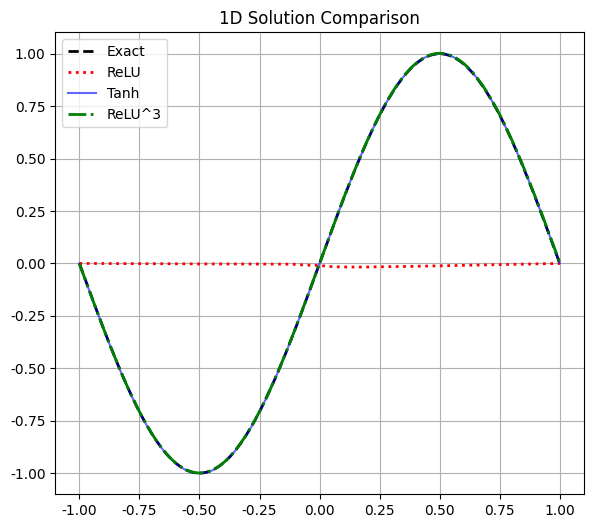

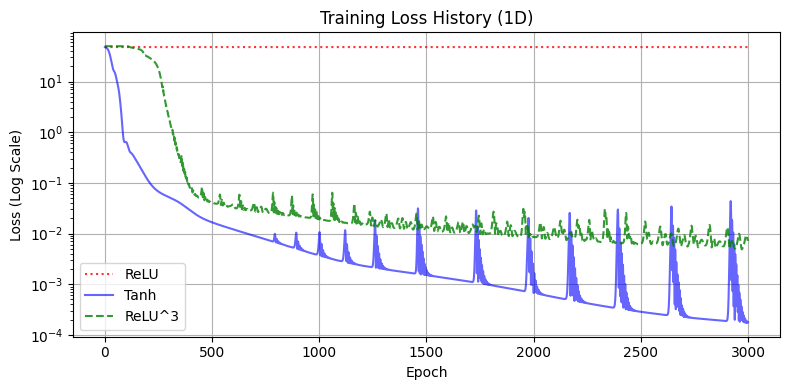

In [6]:
plt.figure(figsize=(15, 6))
x_test = torch.linspace(-1, 1, 200).view(-1, 1).to(device)
with torch.no_grad():
    u_true = prob.exact_u(x_test).cpu().numpy()
    u_p_relu = model_relu(x_test).cpu().numpy()
    u_p_tanh = model_tanh(x_test).cpu().numpy()
    u_p_cubic = model_cubic(x_test).cpu().numpy()

x_plot = x_test.cpu().numpy()

plt.subplot(1, 2, 1)
plt.plot(x_plot, u_true, 'k--', label='Exact', linewidth=2)
plt.plot(x_plot, u_p_relu, 'r:', label='ReLU', linewidth=2)
plt.plot(x_plot, u_p_tanh, 'b-', label='Tanh', alpha=0.6)
plt.plot(x_plot, u_p_cubic, 'g-.', label='ReLU^3', linewidth=2)
plt.title(f'1D Solution Comparison')
plt.legend()
plt.grid()


plt.figure(figsize=(8, 4))
plt.semilogy(loss_relu, 'r:', label='ReLU', alpha=0.8)
plt.semilogy(loss_tanh, 'b-', label='Tanh', alpha=0.6)
plt.semilogy(loss_cubic, 'g--', label='ReLU^3', alpha=0.8)
plt.title(f'Training Loss History ({DIMENSION}D)')
plt.xlabel('Epoch')
plt.ylabel('Loss (Log Scale)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [7]:
DIMENSION=2
EPOCHS = 3000
prob = ProblemConfig(dim=DIMENSION)

print(">>> ReLU", flush=True)
model_relu = PINN(input_dim=DIMENSION, activation_fn=nn.ReLU).to(device)
loss_relu = train_pinn(model_relu, prob, epochs=EPOCHS)


print(">>> Tanh", flush=True)
model_tanh = PINN(input_dim=DIMENSION, activation_fn=nn.Tanh).to(device)
loss_tanh = train_pinn(model_tanh, prob, epochs=EPOCHS)


class CubicReLU(nn.Module):
    def forward(self, x):
        return torch.pow(torch.relu(x), 3)
print(">>> ReLU^3", flush=True)
model_cubic = PINN(input_dim=DIMENSION, activation_fn=CubicReLU).to(device)
loss_cubic = train_pinn(model_cubic, prob, epochs=EPOCHS)


>>> ReLU
--- Training 2D PINN with ReLU ---
Ep 0: Loss 101.12105 (Phys: 101.05060, BC: 0.00705)
Ep 500: Loss 101.05060 (Phys: 101.05060, BC: 0.00000)
Ep 1000: Loss 101.05060 (Phys: 101.05060, BC: 0.00000)
Ep 1500: Loss 101.05060 (Phys: 101.05060, BC: 0.00000)
Ep 2000: Loss 101.05060 (Phys: 101.05060, BC: 0.00000)
Ep 2500: Loss 101.05060 (Phys: 101.05060, BC: 0.00000)
Done. Time: 17.63s

>>> Tanh
--- Training 2D PINN with Tanh ---
Ep 0: Loss 97.20110 (Phys: 96.38551, BC: 0.08156)
Ep 500: Loss 0.10277 (Phys: 0.04180, BC: 0.00610)
Ep 1000: Loss 0.03175 (Phys: 0.00858, BC: 0.00232)
Ep 1500: Loss 0.00916 (Phys: 0.00356, BC: 0.00056)
Ep 2000: Loss 0.00426 (Phys: 0.00240, BC: 0.00019)
Ep 2500: Loss 0.00233 (Phys: 0.00152, BC: 0.00008)
Done. Time: 22.87s

>>> ReLU^3
--- Training 2D PINN with CubicReLU ---
Ep 0: Loss 93.58729 (Phys: 93.58729, BC: 0.00000)
Ep 500: Loss 0.40960 (Phys: 0.29264, BC: 0.01170)
Ep 1000: Loss 0.03335 (Phys: 0.01877, BC: 0.00146)
Ep 1500: Loss 0.02081 (Phys: 0.01508, BC

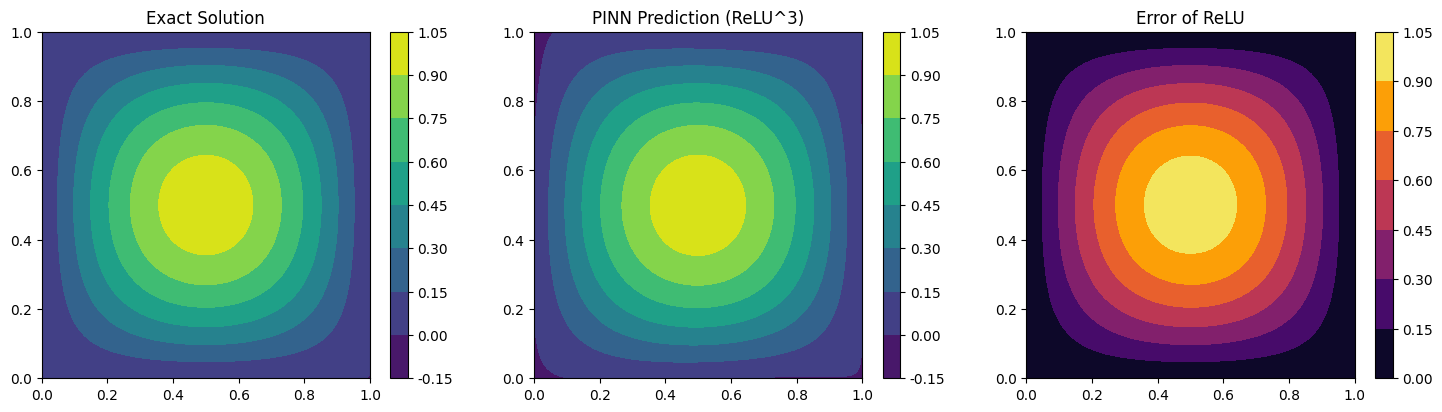

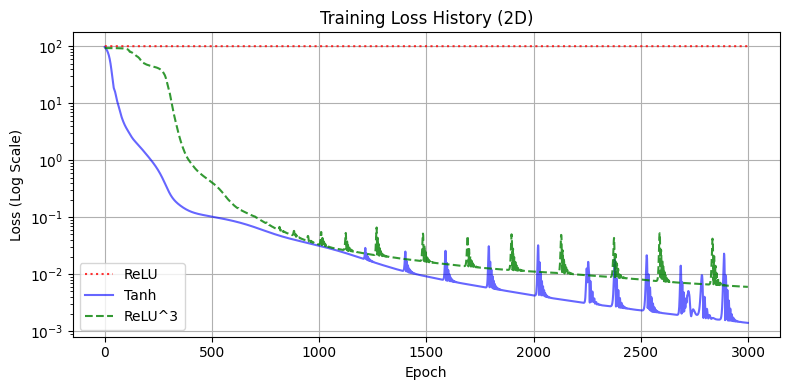

In [8]:
plt.figure(figsize=(18, 4.5))
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x, y)
input_tensor = torch.tensor(np.column_stack((X.flatten(), Y.flatten())), dtype=torch.float32).to(device)

with torch.no_grad():
    u_true = prob.exact_u(input_tensor).cpu().numpy().reshape(100, 100)
    u_p_cubic = model_cubic(input_tensor).cpu().numpy().reshape(100, 100)
    u_p_relu = model_relu(input_tensor).cpu().numpy().reshape(100, 100)


plt.subplot(1, 3, 1)
plt.contourf(X, Y, u_true, cmap='viridis')
plt.title('Exact Solution')
plt.colorbar()

plt.subplot(1, 3, 2)
plt.contourf(X, Y, u_p_cubic, cmap='viridis')
plt.title('PINN Prediction (ReLU^3)')
plt.colorbar()

plt.subplot(1, 3, 3)
plt.contourf(X, Y, np.abs(u_true - u_p_relu), cmap='inferno')
plt.title('Error of ReLU')
plt.colorbar()


plt.figure(figsize=(8, 4))
plt.semilogy(loss_relu, 'r:', label='ReLU', alpha=0.8)
plt.semilogy(loss_tanh, 'b-', label='Tanh', alpha=0.6)
plt.semilogy(loss_cubic, 'g--', label='ReLU^3', alpha=0.8)
plt.title(f'Training Loss History ({DIMENSION}D)')
plt.xlabel('Epoch')
plt.ylabel('Loss (Log Scale)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
